In [1]:
import pandas as pd
import cv2

import os

import numpy as np


In [2]:
from data_augmentation.data_augmentation import DataAugmentation
dataAugm = DataAugmentation(data_dir="data",
                            target_dir="/home/dmitrii/GitHub/AnomaliesRecycling/data/copy_and_paste/results",
                            zero_lid_dir='data_augmentation/data/zero_lid.csv',
                            one_lid_dir='/data_augmentation/data/one_lid.csv')


Generating and saving masks for image 0 of 1331
Generating and saving masks for image 100 of 1331
Generating and saving masks for image 200 of 1331
Generating and saving masks for image 300 of 1331
Generating and saving masks for image 400 of 1331
Generating and saving masks for image 500 of 1331
Generating and saving masks for image 600 of 1331
Generating and saving masks for image 700 of 1331
Generating and saving masks for image 800 of 1331
Generating and saving masks for image 900 of 1331
Generating and saving masks for image 1000 of 1331
Generating and saving masks for image 1100 of 1331
Generating and saving masks for image 1200 of 1331
Generating and saving masks for image 1300 of 1331


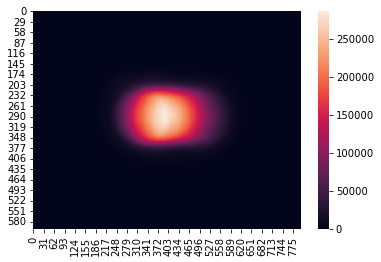

In [3]:
dataAugm.extract_masks()
summed_mask = dataAugm.get_sum_binary_mask()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

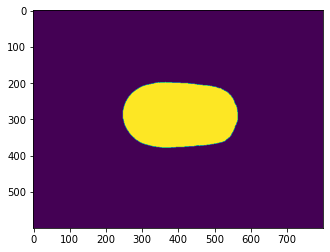

In [4]:
dataAugm.get_percentile_sum_binary_mask(summed_mask=summed_mask, percentile=90)

In [5]:
from PIL import Image
import cv2
from IPython.display import display
def show_cv(img_in):
    img = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    display(Image.fromarray(img))

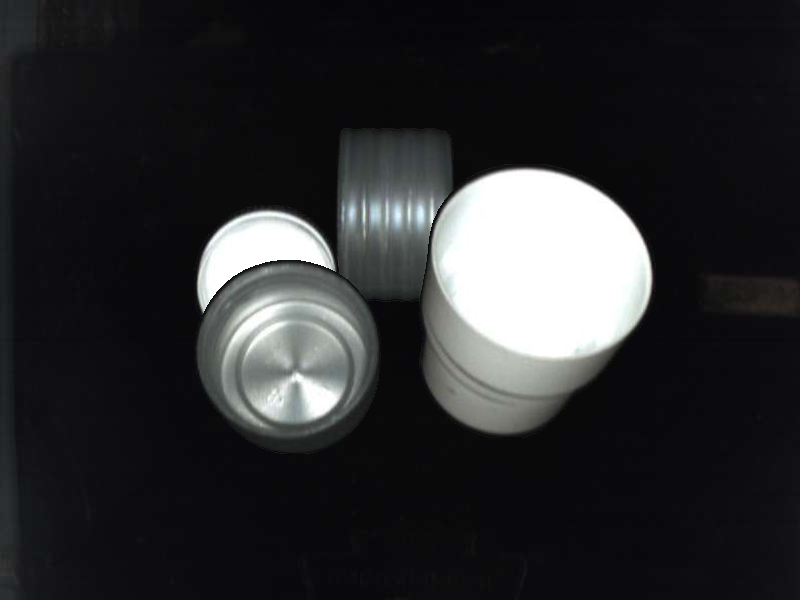

In [7]:
show_cv(dataAugm.copy_and_paste(4))

In [8]:
dataAugm.generate({0:1, 1:1, 2:1, 3:1, 4:2, 5:1, 6:1})

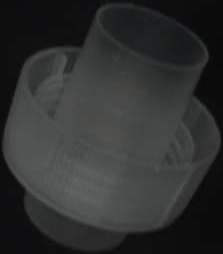

(254, 223, 3)


In [15]:
#generate BB
img = dataAugm.masks[0]
x,y,w,h = cv2.boundingRect(img.cnt)
image = img.image
#cv2.rectangle(image, (x, y), (x + w, y + h), (0,0,255), 2)
image = image[y:y+h, x:x+w]
show_cv(image)
print(image.shape)